<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter15/TrOCR_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip
%pip install -q datasets jiwer
%pip -q install torch_snippets torch_summary editdistance
%pip -q install accelerate

In [ ]:
from torch_snippets import *
from torchsummary import summary
import editdistance

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fname2label = lambda fname: stem(fname).split('@')[0]
images = Glob('synthetic-data/*')

In [ ]:
len(images)

25132

In [ ]:
images_list = []
labels_list = []
for image in images:
  images_list.append(str(image).split('/')[-1])
  labels_list.append(fname2label(image))
df = pd.DataFrame([images_list[:5000], labels_list[:5000]]).T
df.columns = ['file_name', 'text']
df.head()

,file_name,text
0,memory@q1PEVc.png,memory
1,although@02RrC8.png,although
2,any@njsVQo.png,any
3,charge@E6N8fq.png,charge
4,necessary@SZwnRs.png,necessary


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
train_dataset = IAMDataset(root_dir='/content/synthetic-data/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/synthetic-data/',
                           df=test_df,
                           processor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 4500

Number of validation examples: 500

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values
torch.Size([3, 384, 384])

labels
torch.Size([128])

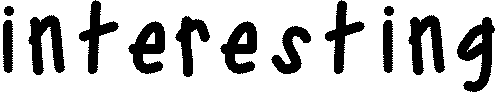

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

interesting

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [ ]:
for name, param in model.named_parameters():
    param.requires_grad = True
    #print(name)
    # if name=='decoder.output_projection.weight':
    #     param.requires_grad = True


In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=100,
    num_train_epochs = 10
)

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(

    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
100,1.468400,1.485709,0.248651
200,1.201000,1.186254,0.245412
300,1.375000,1.082842,0.106513
400,1.034500,1.100040,0.167686
500,1.183800,1.077437,0.183879
600,0.777200,0.947086,0.169845
700,0.913500,1.018770,0.154372
800,0.759700,0.909072,0.077726
900,0.965700,0.894016,0.082044
1000,0.940400,0.830890,0.065491


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
# Load and preprocess the image
image = Image.open("/content/synthetic-data/American@3WPOqS.png").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values

# Perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    generated_ids = model.generate(pixel_values.to(device))

# Decode the generated ids to text
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted Text:", predicted_text)

Predicted Text: American